# Fitting star profiles with a PSF model using DAOPHOT NSTAR-MCMC from Python

Tutorial showing how to use NSTAR-MCMC from Python with a shared Fortran library.

                  Version 1.1 - 25 April 2025
                         Clément Ranc

This code runs NSTAR-MCMC_PYWRAPPER, which has been developed from NSTAR-MCMC.<br>NSTAR-MCMC was initially developed by Sean Terry:

- Code and documentation: https://github.com/skterry/daophot_mcmc
- Article: Terry et al. 2021, AJ, 161, 54.

NSTAR-MCMC is a modified version of the subroutine NSTAR of DAOPHOT-II developed by Peter Stetson:
- Code: http://www.star.bris.ac.uk/~mbt/daophot/
- Documentation: http://www.astro.wisc.edu/sirtf/daophot2.pdf

The technical benefits of using the approach decribed in this tutorial include:

- The possibility of using any Python package able to perform an MCMC. For example, we will use the widely recognized EMCEE package, running an _Affine Invariant_ algorithm (Foreman-Mackey et al. 2013, PASP, 125, 306).
- The possibility of using your own customized MCMC algorithm.
- The possibility of using any kind of optimization algorithm, such as the gradient method. We will show an example of using the Levenberg-Marquardt algorithm to find the best-fit model.
- The ability to access the residuals (not only the chi-square) from within Python.
- Priors on parameters can be added efforlessly, without any need for a new compilation.
- The fitting process can be parallelized and run on many CPUs.
- The back-and-forth of parameters between DAOPHOT and Python does not involve any file thanks to the shared python library I created, which speeds up the code.
- The possibility of continuing an MCMC run you wish to be longer without any need to start again from the beginning.

Although the physical models include:

- a 2-star model,
- a 3-star model,
- a 4-star model.

**the package is currently undergoing a major update. At this stage, only the 2-star model is up-to-date. The other models will be updated soon. I apologize for the incovenience.**

## Requirement and installation

Please follow the instructions given in the [README.md](https://github.com/clementranc/nstarwrap/blob/main/README.md#installation-of-the-shared-library) file of the GitHub repository before studying this tutorial.

## Real world example: a 2-star fit

**Goal:** In this section, we show how to perform a 2-star fit.

A clean directory includes:
- An image, here `image.fits`
- A PSF model produced by DAOPHOT, here `image.psf`
- A list of stars of interest produced by DAOPHOT Group command, here `image.grp`

We start by defining some basic variables, most of them are self explanatory.

In [1]:
# Filenames
image_file_name = 'image.fits'
psf_model_file_name = 'image.psf'
group_file_name = 'image.grp'

# Needed parameters from the daophot.opt file or standard values.
watch = 0.0
fitrad = 9.8
e1 = 0.75
e2 = 5.0

# Fitting box limits
box_xmin, box_xmax, box_ymin, box_ymax = 1100, 1128, 1171, 1197

# Initial position in the parameter space.
# (x, y) position of star 1 (the brightest) and star 2 (the faintest),
# Flux ratio between star 2 and star 1
x1fg, y1fg = 1112.536, 1183.238
x2fg, y2fg = 1112.368, 1189.931
flux_ratio12_fg = 0.584269

Now, we need to import the Fortran DAOPHOT shared library. MOAna is doing it for you.

In [2]:
# Import the DAOPHOT tools of the Python package MOAna
import nstarwrap.daotools as daotools

# Import the shared library
nstar_wrapper = daotools.NstarPythonWrapper(
    image=image_file_name,
    psf=psf_model_file_name,
    group=group_file_name,
    watch_daophot=watch, 
    fitrad_daophot=fitrad, 
    e1_daophot=e1,
    e2_daophot=e2,
    fitting_box=[box_xmin, box_xmax, box_ymin, box_ymax])

/Users/cr/Recherche/Projets/Codes/DAOPHOT/2025/pydaophot/pywrapper.so


Running the `ATTACH` command load the picture in memory and consists of:

In [3]:
ncol, nrow = nstar_wrapper.attach()
print(f'ncol = {ncol.value}, nrow={nrow.value}')


     image...                                


                                      Picture size:   2290  2290

ncol = 2290, nrow=2290


### Least-square fit and maximum likelihood estimation

First, we are going to use a least-square algorithm to find the best-fitting model close to an initial position in the parameter space. For general purpose, let's use a Levenberg-Marquardt algorithm, less sensitive to local minima than a Newton method. We will use the implementation of the python package `scipy`. The Levenberg-Marquardt algorithm we use compute numerically the Jacobian matrix and minimize the cost function F(x):
```python
minimize F(x) = 0.5 * sum(rho(f_i(x)**2), i = 0, ..., m - 1)
````
where `f_i(x)` is the residual vector evaluated at the parameter space position (x).

In [4]:
# Function that uses nstar-mcmc to evaluate the residual vector
def compute_residual_vector(x):
    chi2, _ = nstar_wrapper.nstar_goodness_of_fit(x)
    return nstar_wrapper.residuals

# Define the initial conditions
p0 = [x1fg, y1fg, x2fg, y2fg, flux_ratio12_fg]

# Perform the fit
from scipy.optimize import least_squares
lsq_result = least_squares(compute_residual_vector, p0, method='lm')

Results of the fit:

In [5]:
print(f"Successful fit: {lsq_result['success']}\n{lsq_result['message']}")
print(f"Best-fit parameters:\n   {lsq_result['x']}")
print(f"Cost function of best-fit parameter: {lsq_result['cost']}")

Successful fit: True
`gtol` termination condition is satisfied.
Best-fit parameters:
   [1.112536e+03 1.183238e+03 1.112368e+03 1.189931e+03 5.842690e-01]
Cost function of best-fit parameter: 0.0


The image below displays the position of the two stars (magenta crosses).

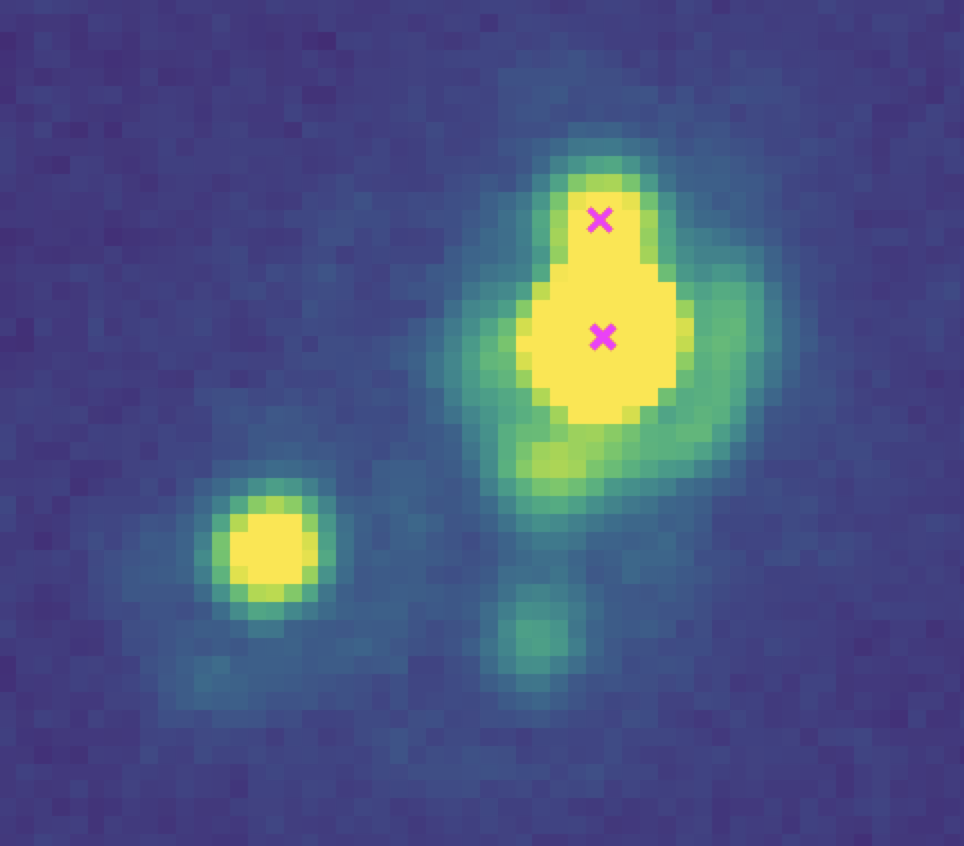

In [6]:
from IPython.display import Image
Image(filename='illustrations/Levenberg-Marquardt.png', width=200)

### MCMC, prior and posterior distributions

We know the best-fit. Great! But a posterior distribution and error bars are much better!

The MCMC performed below follows the same general approach as NSTAR-MCMC developed by Sean Terry, i.e., the badness-of-fit is computed exactly in the same way, and the fit is performed inside a fitting box. However, the constraints on the parameters are managed in a different way, adopting a Bayesian approch, i.e., using a prior distribution.

In [7]:
# Define the log-prior
def log_prior(x):
    if (box_xmin < x[0] < box_xmax)\
        and (box_xmin < x[2] < box_xmax)\
        and (box_ymin < x[1] < box_ymax)\
        and (box_ymin < x[3] < box_ymax)\
        and (0 < x[4]):
        return 0.0
    return -np.inf

# Define the log-probability function
def log_probability(x):
    x1, y1, x2, y2, fratio = x
    
    # Trick: we want star 1 to always be the brightest.
    # TODO: remove this trick.
    theta = x
    if fratio > 1:
        fratio = 1.0 / fratio
        x1, x2, y1, y2 = x[2], x[0], x[3], x[1]
        theta = [x[2], x[0], x[3], x[1], fratio]
        
    # Evaluate the log(prior)
    lp = log_prior(theta)
    if np.isinf(lp):
        return lp, 0.0
    
    # Run NSTAR-MCMC to compute the chi-square and the total flux in the fitting box
    chisq, total_flux = nstar_wrapper.nstar_goodness_of_fit(theta)
    
    return -0.5 * chisq + lp, total_flux

Now, let's initialize the chains' position to a random position in the
parameter space, close to the centroid positions we entered on top
of this notebook. We also want all the chains to be inside the fitting
box.

In [8]:
# Number of parameters you want to fit
ndim = 5

# We will use an Affine-invariant MCMC, implemented in EMCEE package.
# It is very similar to the Differential-evolution MC, and deals very
# well with the non linear posterior distributions.
# Number of chains running in parallel (must be at least 2x the number
# of parameters fitted and even.
nwalkers = 10

# Initial center of the 2 stars in the complex plane
star1 = x1fg + 1j * y1fg
star2 = x2fg + 1j * y2fg

# We want to initialize the chains' position randomly around these 
# position, not to far. Let's use a Normal distribution in 2D around
# the star centers. We ALSO want the stars to be inside the fitting
# box intially.
import numpy as np
SEED = 42  # Random seed for reproductibility and debugging
rng = np.random.default_rng(SEED)  # Initialize the random generator

mu, sigma = 0, 1
inside_box = [True]
i = 0
while(any(inside_box)):
    p1 = star1 + rng.normal(mu, sigma, nwalkers) * np.exp(1j * rng.uniform(0, 2*np.pi, nwalkers))
    p2 = star2 + rng.normal(mu, sigma, nwalkers) * np.exp(1j * rng.uniform(0, 2*np.pi, nwalkers))
    p0 = np.array([p1.real, p1.imag, p2.real, p2.imag, 
                   flux_ratio12_fg + rng.normal(0, 0.3, nwalkers)]).T
    inside_box = np.array([log_prior(a) for a in p0]) < 0
    i = i+1
    if i > 10:
        print('Please change the box size of adapt the random choices to your box size.')
        break

# We replace the position in parameter space of the first chain by the
# initial conditions we manually entered on top of this notebook.
p0[0] = np.array([x1fg, y1fg, x2fg, y2fg, flux_ratio12_fg])

We are ready to initialize the EnsembleSampler.

In [9]:
# We will save the MCMC output in an HDF5 format (you can change that
# if you wish), and we want to use the EMCEE Python package.
filename = "my_mcmc.h5"

import emcee
backend = emcee.backends.HDFBackend(filename)

# Start a new MCMC, so we reset the backend
backend.reset(nwalkers, ndim)

# We will use blobs to carry the total flux (not fitted by EMCEE)
nstar_params_name_light = ["z0"]
dtype = [(a, np.float64) for a in nstar_params_name_light]

# Initialization of the sampler with all the previous parameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
    blobs_dtype=dtype, backend=backend)


Now we run the MCMC.

In [10]:
# Start the MCMC run
max_n = 1000  # Length of each MCMC chain

import time
start = time.time()
sampler.run_mcmc(p0, max_n, progress=True);
end = time.time()
run_time = end - start

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.71it/s]


Let's plot the correlations and the best fit model.

In [11]:
# Print basic information about the MCMC run
burnin = 0
print(f'Autocorrelations:')
print(f'   [Shape: {sampler.get_chain(discard=burnin, flat=False).shape}]')
print(f'   {sampler.get_autocorr_time(quiet=True)}')
samples = sampler.get_chain(discard=burnin, flat=True)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True)
out = sampler.get_blobs(discard=burnin, flat=True)
print(f'Zeropoint Mag: {nstar_wrapper.zpmag.value:.4f}')

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 87.98009088  55.1344075  113.64913632 118.859329    23.89321591]


Autocorrelations:
   [Shape: (1000, 10, 5)]
   [ 87.98009088  55.1344075  113.64913632 118.859329    23.89321591]
Zeropoint Mag: 13.5920


In [12]:
import pandas as pd
colnames = np.array(['x1', 'y1', 'x2', 'y2', 'flux_ratio'])
mcmc_out = pd.DataFrame(samples, columns=colnames)
mcmc_out['FTOTAL'] = out['z0']

# Don't forget to take into account when flux ratio > 1.0
# TODO: remove that!
mask = mcmc_out['flux_ratio'] > 1
mcmc_out.loc[mask, 'flux_ratio'] = 1 / mcmc_out.loc[mask, 'flux_ratio']
x1 = mcmc_out.loc[mask, 'x2']
y1 = mcmc_out.loc[mask, 'y2']
x2 = mcmc_out.loc[mask, 'x1']
y2 = mcmc_out.loc[mask, 'y1']
mcmc_out.loc[mask, 'x1'] = x1
mcmc_out.loc[mask, 'y1'] = y1
mcmc_out.loc[mask, 'x2'] = x2
mcmc_out.loc[mask, 'y2'] = y2
mcmc_out['chi2'] = - 2.0 * log_prob_samples
mcmc_out['dchi2'] = mcmc_out['chi2'] - np.min(mcmc_out['chi2'])

display(mcmc_out[mcmc_out['chi2']==np.min(mcmc_out['chi2'])])

,x1,y1,x2,y2,flux_ratio,FTOTAL,chi2,dchi2
7853,1112.534477,1183.227566,1112.346688,1190.013372,0.857215,0.860422,183.522004,0.0


Each sub-plot must be 4.863in x 4.863in to have a figure of 6.614in. Okay! I'm using it!


<Figure size 640x480 with 0 Axes>

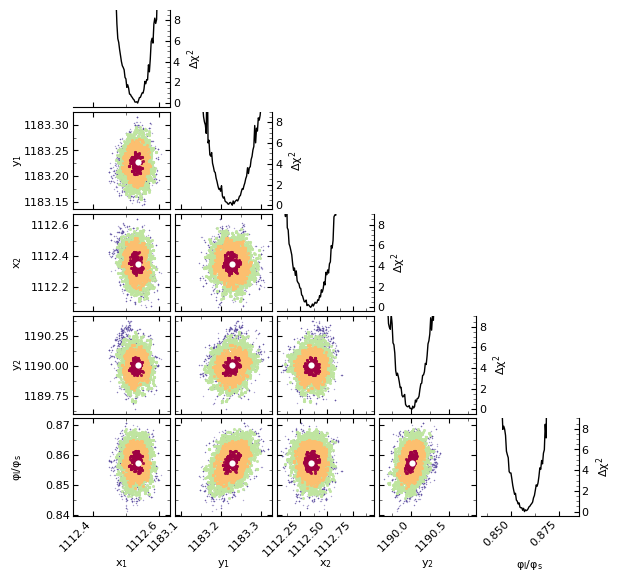

In [13]:
import moana

# Plot result of fitted parameters
labels = ['x1', 'y1', 'x2', 'y2', 'flux_ratio']

label_display = dict({'x1': r'x_1', 'x2': r'x_2', 'y1': r'y_1', 'y2': r'y_2',   
    'flux_ratio': r'\varphi_l/\varphi_s'})

mask = mcmc_out['dchi2'] < 100

posterior = moana.SampledPosterior(mcmc_out[mask], labels=labels)
fig, ax = posterior.corner_plot(credible_intervals=False, diagonal='chi2', 
    rotation=45, show_samples=True, labels=label_display);

bf = mcmc_out[mcmc_out['chi2']==np.min(mcmc_out['chi2'])][labels].values[0]
[ax[j][i].scatter(bf[i], bf[j], s=20, lw=0, marker='o', c='w') 
 for i in range(len(labels)) for j in range(len(labels)) if i<j]

# Save the figure
fig.savefig('correlation.png', bbox_inches='tight', dpi=72, pad_inches=0.1)

You should get a new "correlation.png" file that looks like this one:

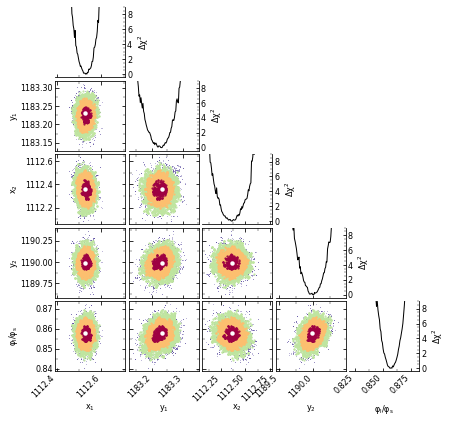

In [14]:
Image(filename='illustrations/Correlation.png', width=600)

### Error-bar renormalization

In [15]:
print(f'Degrees of freedom: {nstar_wrapper.dof:d}')
print(f"Best chi-square: {np.min(mcmc_out['chi2']):.4f}")
print(f"Suggested rescaling factor: {np.min(mcmc_out['chi2'])/nstar_wrapper.dof:.6f}")

Degrees of freedom: 777
Best chi-square: 183.5220
Suggested rescaling factor: 0.236193


Before running again the MCMC, we will make some optimization and explore the potential of the python implementation of DAOPHOT. We do the following changes:
- Add a chi-square rescaling factor to get more accurate error bars.
- We will prepare the MCMC to run it on several CPU in parallel to spead up the code.
- We will use a local binary file to store the FITS image to avoid running multiple times the ATTACH command when running the code in parallel. This is optional but highly recommended, as the code will be faster and more stable.

To start this new adventure, please proceed to the tutorial 2. The tuto 2 is strongly recommended and seen as essential.